In [103]:
import pickle
import pandas as pd
import numpy as np

#data = [df,spray,(weather_st1, weather_st2)]

with open('cleanData.pickle', 'rb') as f:
    data = pickle.load(f)

df = data[0]
spray = data[1]

In [104]:
from scipy.spatial import cKDTree
import numpy as np

spray_dict = {}

for i in spray['Date'].dt.date.unique():
    spray_dict[i] = cKDTree( list(spray[spray['Date'] >= i ].loc[:,'Location']) )

In [107]:
spray_dates = list(spray_dict.keys())

In [142]:
def nearSpray(data, spray_dict, dist = .1):
    toRet = {}
    
    for l in data['Location'].unique():
        toRet[l] = {}
        trapDates = data[ data['Location'] ==l]['Date'].unique()
        trapDates.sort()
        trapDates = [pd.Timestamp(d).date() for d in trapDates]
        if trapDates[-1] > firstSpray:
            for tDate in trapDates:
                for sDate in spray_dates:
                    before, after = False, False
                    
                    if ((tDate - sDate < pd.Timedelta(0)) &
                    (tDate-sDate > pd.Timedelta(days=-8)) & 
                   (spray_dict[sDate].query(l,1)[0]*69 < dist)):
                        before = True
                    
                    if ((tDate - sDate > pd.Timedelta(0)) &
                    (tDate-sDate < pd.Timedelta(days=8)) & 
                   (spray_dict[sDate].query(l,1)[0]*69 < dist)):
                        #print('hi')
                        after = True
                    
                toRet[l][tDate] = (before, after)
                
                toRet2 = {}
                for k1 in toRet:
                    for k2 in toRet[k1]:
                        toRet2[(k1,k2)] = toRet[k1][k2]
                
    df = pd.DataFrame().from_dict(toRet2).transpose()
    df.columns = ['SprayBefore', 'SprayAfter']
    df['Loc'] = df.index.map(lambda x: x[0])
    df['Date'] = df.index.map(lambda x: x[1])
    df.index = range(0,len(df))
                
    return df

In [143]:
nearspray = nearSpray(df, spray_dict)

In [144]:
nearspray.head()

,SprayBefore,SprayAfter,Loc,Date
0,False,False,"(-87.930995, 41.957799)",2009-06-03
1,False,False,"(-87.930995, 41.957799)",2009-06-05
2,False,False,"(-87.930995, 41.957799)",2009-06-15
3,False,False,"(-87.930995, 41.957799)",2009-06-22
4,False,False,"(-87.930995, 41.957799)",2009-06-29


### Deprecated

In [44]:
locSprayDates = {}
spray_dates = list(spray_dict.keys())
spray_dates.sort(reverse = True)
deltas = []
firstSpray = spray_dates[-1]

for l in df['Location'].unique():
    trapDates = df[ df['Location'] ==l]['Date'].unique()
    trapDates.sort()
    trapDates = [pd.Timestamp(d).date() for d in trapDates]
    
    pd.Timedelta(8)
    if trapDates[-1] > firstSpray:
        beforeDates = []
        beforeDist = []
        afterDates = []
        afterDist = []
        for tDate in trapDates:
            for sDate in spray_dates:
                deltas.append(tDate-sDate)
                    
                if ((tDate - sDate < pd.Timedelta(0)) & (tDate-sDate > pd.Timedelta(days=-8)) ):
                    
                    beforeDates.append((tDate, sDate, tDate-sDate))
                    beforeDist.append(spray_dict[sDate].query(l,1))
                    
                if (tDate - sDate > pd.Timedelta(0)) & (tDate-sDate <pd.Timedelta(days =8)):
                    
                    afterDates.append((tDate, sDate, tDate-sDate))
                    afterDist.append(spray_dict[sDate].query(l,1))
        locSprayDates[l] = (beforeDates, beforeDist, afterDates, afterDist)
        
    


In [159]:
str(np.min).split(' ')[1]

'amin'

In [ ]:
agg_df = pd.DataFrame(columns=['Trap', 'Date_end',
                               'Tmax_max', 'Tmin_min', 'Tavg_avg', 
                               'DewPoint_max', 'DewPoint_min', 'DewPoint_avg',
                              'StnPressure_max','StnPressure_min', 'StnPressure_avg',
                              'PrecipTotal_total',
                              'AvgSpeed_avg'])

In [160]:
def aggWeatherForObs(data, weather):
    agg = []

    def calculate_agregate (trap_df, weather_sub, end_date):

        toRet = pd.Series()

        toRet['Trap'] = trap_df.loc[0,'Trap'] 
        toRet['Date_end'] = end_date

        for c in ['DewPoint', 'StnPressure', 'AvgSpeed']:
            for f in [np.max, np.min, np.mean]:
                toRet.loc[c+str(f).split(' ')[1]] = f(weather_sub[c])

        toRet['temp_max'] = weather_sub['Tmax'].max()
        toRet['temp_min'] = weather_sub['Tmin'].min()
        toRet['temp_avg'] = weather_sub['Tavg'].mean()

        toRet['precip_total'] = weather_sub['PrecipTotal'].sum()
        toRet['precip_avg'] = toRet['precip_total'] / len(weather_sub)

        return toRet

    trapDFs =[]
    for trap in data['Trap'].unique():
        trapDFs.append(df[ df['Trap'] == trap ])

    for tDF in trapDFs:

        dates = tDF.sort_values('Date')['Date'].unique()
        dates = np.insert(dates, 0, dates[0] - pd.Timedelta(days=15))

        dateRanges=[]

        for i in range(len(dates)-1):
            dateRanges.append( (dates[i] , dates[i+1]) )

            start_date = dateRanges[i][0]
            end_date = dateRanges[i][1]

            #Select dataframe rows between two dates in weather
            mask = (weather['Date'] > start_date) & (weather['Date'] <= end_date)

            weather_sub = weather_st1.loc[mask]

            agg.append( calculate_agregate(tDF, weather_sub, end_date) )
            
    return pd.DataFrame(agg)
        

In [52]:
import matplotlib.pyplot as plt

%matplotlib inline

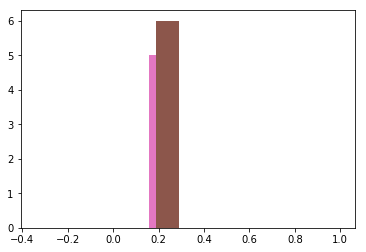

In [75]:
df2 = pd.DataFrame().from_dict(locSprayDates)
df2 = df2.transpose()
for i in range(len(df2)):
    dists = df2.iloc[i,1]
    plt.hist([d[0]*69 for d in dists if (d[0]*69>.1) & (d[0]*69<.2)
             ])